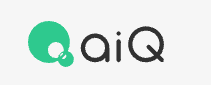

[disclaimer](../../disclaimer.txt/)

# TruValue Data Evaluation

[[?]]Factset TruValue はスーパーマーケット、ドラッグストアやコンピニなどの小売店舗で販売された商品の売上データを TICKER ごとにまとめたものです

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import plotly.io

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

sys.path.append('../..')
from aiq_strategy_robot.data.data_accessor import DAL
from utils.shortcut import truvalue_dataset as sc

## データロード & AltDataEvaluatorの作成

- standard data handler のインスタンスを作成する
- data handler はデータ取得やデータ加工のライブラリを保持するオブジェクト

In [3]:
sdh = DAL()

当該サンプルではデータファイルのサンプルを使用して以降の説明を行います.

In [4]:
# Price Data (origin: FactSet HTTP API)
data_id_price = sc.register_market_prices(sdh)
display(sdh.get_raw_data(data_id_price).tail())


# ☆TruValue data (origin: FactSet Snowflake)
data_id_tv = sc.register_tv(sdh)
display(sdh.get_raw_data(data_id_tv).tail())

# Set Alias (Optional)
sdh.set_alias({
    data_id_price: 'mkt',
    data_id_tv: 'truvalue',
})

sdh.extract_definition


fsymId  TICKER_REGION    volume   open   high    low  \
TICKER  DATETIME                                                             
9997-JP 2023-10-27  BT5ZHY-R           9997  290300.0  622.0  628.0  622.0   
        2023-10-30  BT5ZHY-R           9997  409300.0  622.0  625.0  607.0   
        2023-10-31  BT5ZHY-R           9997  528300.0  610.0  613.0  604.0   
        2023-11-01  BT5ZHY-R           9997  421200.0  627.0  633.0  619.0   
        2023-11-02  BT5ZHY-R           9997  323800.0  631.0  631.0  621.0   

                    close currency  
TICKER  DATETIME                    
9997-JP 2023-10-27  626.0      JPY  
        2023-10-30  612.0      JPY  
        2023-10-31  612.0      JPY  
        2023-11-01  628.0      JPY  
        2023-11-02  628.0      JPY

MATERIALITY_ADJ_INSIGHT  MATERIALITY_IND_PCTL  \
TICKER  DATETIME                                                    
9997-JP 2023-11-16                    64.42                 40.63   
        2023-11-17                    64.41                 40.35   
        2023-11-18                    64.40                 40.28   
        2023-11-19                    64.35                 40.37   
        2023-11-20                    64.40                 40.23   

                    ALL_CATEGORIES_ADJ_INSIGHT  ALL_CATEGORIES_INSIGHT  \
TICKER  DATETIME                                                         
9997-JP 2023-11-16                       76.55               76.545724   
        2023-11-17                       76.56               76.564881   
        2023-11-18                       76.58               76.583965   
        2023-11-19                       76.60               76.602976   
        2023-11-20                       76.62               76.621916   

                    ALL_CATEGORIES_MOMENTUM  ALL_CATEGORIES_PULSE  
TICKER  DATETIME                                                   
9997-JP 2023-11-16                81.457731               81.5853  
        2023-11-17                81.409830               81.5853  
        2023-11-18                81.362007               81.5853  
        2023-11-19                81.314263               81.5853  
        2023-11-20                81.266596               81.5853

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,FACTSET,gpd_prices,Unknown,mkt,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[TICKER, DATETIME]",2016-01-04 00:00:00,2023-11-02 00:00:00
2,RawData,FACTSET,TrueValue,Unknown,truvalue,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[TICKER, DATETIME]",2016-01-01 00:00:00,2023-11-20 00:00:00


### AltDataEvaluatorを作成

In [5]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

## 相関計算

Factset TruValue のデータの性質から財務データ（四半期売上高）の間に相関関係があることが期待される。  
その仮説が正しいのかここでは検証していきます。

### 株価変化率との相関

> ここでは週次データに変換して分析します.

In [6]:
resample_term = 'W-FRI'

mkt_W_open_id = sdh.transform.resample(data_id=data_id_price, fields='open', rule=resample_term, func='first', label='left', closed='left').variable_ids[-1]

tv_last_W_ids = sdh.transform.resample(data_id=data_id_tv, rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_mean_W_ids = sdh.transform.resample(data_id=data_id_tv, rule=resample_term, func='mean', label='left', closed='left').variable_ids
tv_sum_W_ids = sdh.transform.resample(data_id=data_id_tv, rule=resample_term, func='sum', label='left', closed='left').variable_ids

In [7]:
ori_cols = sdh.get_raw_data(data_id_tv).columns.to_list()
ori_cols

['MATERIALITY_ADJ_INSIGHT',
 'MATERIALITY_IND_PCTL',
 'ALL_CATEGORIES_ADJ_INSIGHT',
 'ALL_CATEGORIES_INSIGHT',
 'ALL_CATEGORIES_MOMENTUM',
 'ALL_CATEGORIES_PULSE']

#### TruValueの集約方法毎に相関を確認

##### 1. resample -last

価格データとTrueValueをプロット

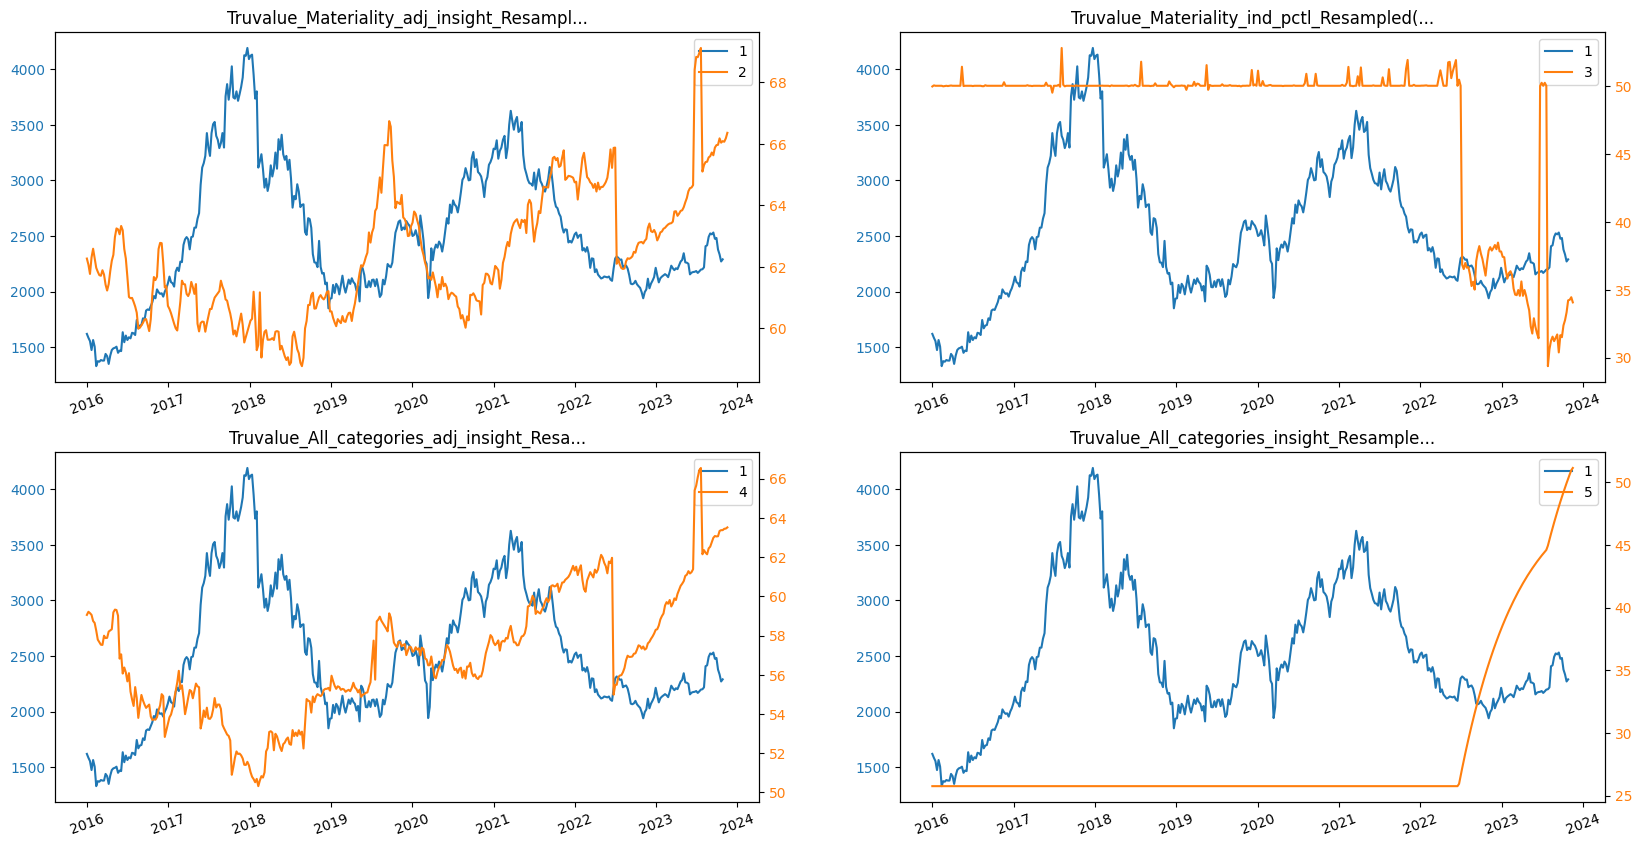

In [8]:
sample_target = "2281-JP"

sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_open_id,
    X= tv_last_W_ids[:4],
    col_num=2,
    vname_len_limit=40,
)

> データの時系列をshiftすることで売上高とのプロットがどのように変化するかを見ます.

In [9]:
tv_shift4_last_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=4).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift8_last_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=8).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift12_last_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=12).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift16_last_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=16).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift20_last_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=20).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids

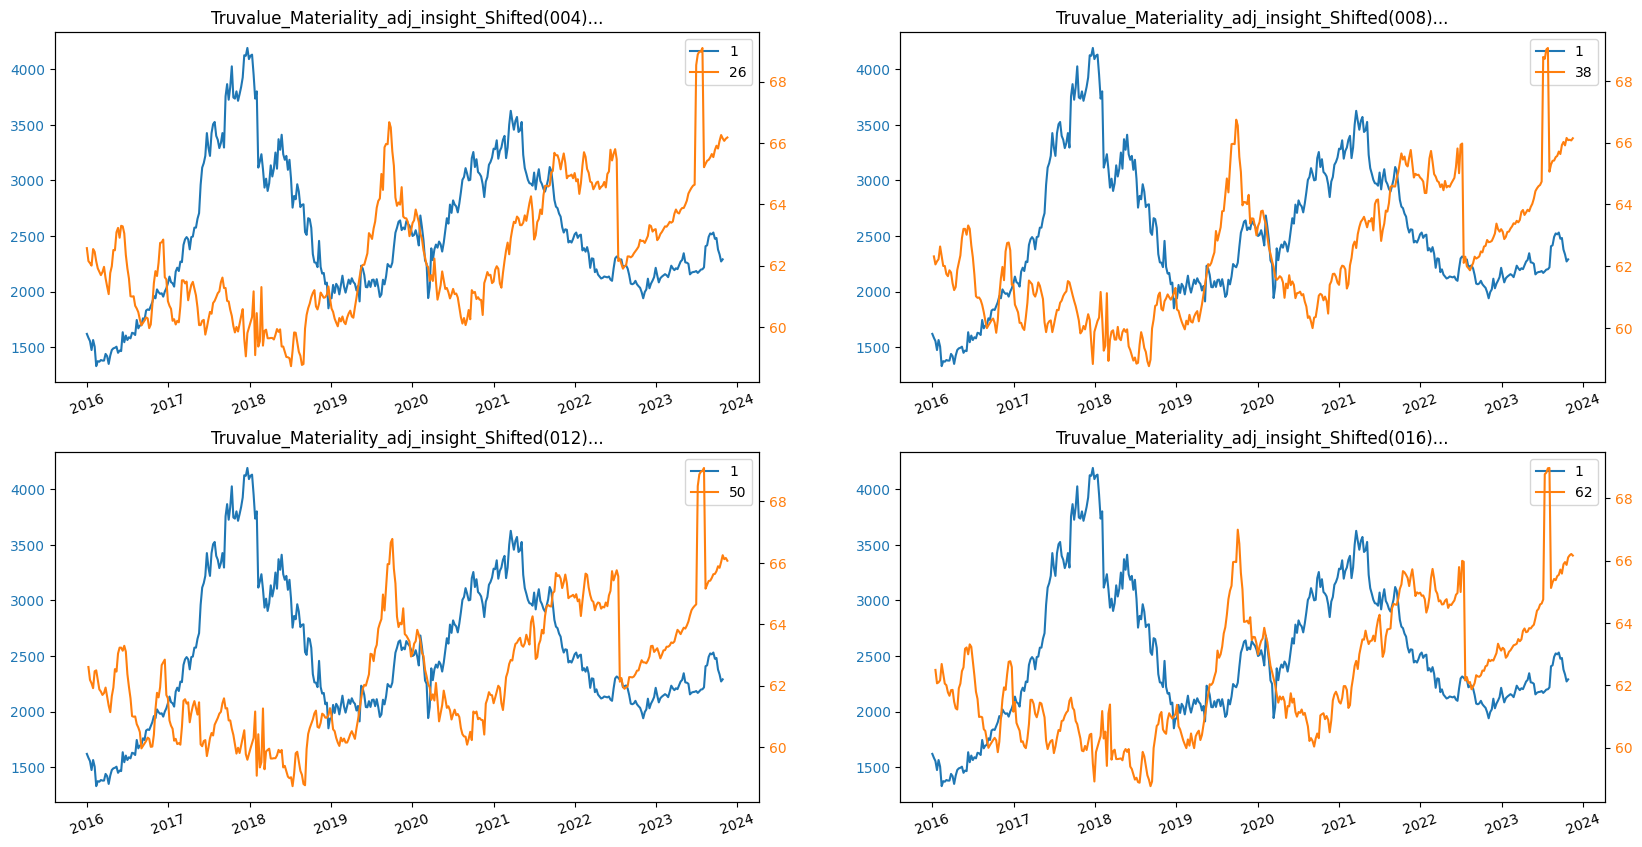

In [10]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_open_id,
    X= [tv_shift4_last_W_ids[0], tv_shift8_last_W_ids[0], 
        tv_shift12_last_W_ids[0], tv_shift16_last_W_ids[0]],
    col_num=2,
    vname_len_limit=45,
)

> 特徴量を対数変換して相関計算を行う<br>
> TruValueはそのままで使用(shiftのみ）

In [11]:
open_return = sdh.transform.dropna(fields=mkt_W_open_id).log_diff(periods=1).multiply_by_scalar(value=100).variable_ids[-1]

In [12]:
rho_pool_last = pd.DataFrame()
rho_pool_last['resample-last, shift=0'] = ade.compu_rho(tv_last_W_ids, open_return, rename_features=ori_cols)
rho_pool_last['resample-last, shift=4'] = ade.compu_rho(tv_shift4_last_W_ids, open_return, rename_features=ori_cols)
rho_pool_last['resample-last, shift=8'] = ade.compu_rho(tv_shift8_last_W_ids, open_return, rename_features=ori_cols)
rho_pool_last['resample-last, shift=12'] = ade.compu_rho(tv_shift12_last_W_ids, open_return, rename_features=ori_cols)
rho_pool_last['resample-last, shift=16'] = ade.compu_rho(tv_shift16_last_W_ids, open_return, rename_features=ori_cols)
rho_pool_last['resample-last, shift=20'] = ade.compu_rho(tv_shift20_last_W_ids, open_return, rename_features=ori_cols)

display(rho_pool_last.xs('t-val', level=1).sort_values(rho_pool_last.columns[0], ascending=False))

,"resample-last, shift=0","resample-last, shift=4","resample-last, shift=8","resample-last, shift=12","resample-last, shift=16","resample-last, shift=20"
ALL_CATEGORIES_PULSE,3.344142,2.860049,2.867985,2.448273,2.339921,2.217730
ALL_CATEGORIES_INSIGHT,2.977132,2.951955,2.924087,2.944935,2.747754,2.664007
ALL_CATEGORIES_MOMENTUM,2.477013,2.465334,2.414705,2.395869,2.250228,2.160098
MATERIALITY_ADJ_INSIGHT,1.705483,1.616806,1.570725,1.543156,1.373864,1.279666
MATERIALITY_IND_PCTL,1.439120,0.737007,0.628365,2.176869,1.348648,0.000215
ALL_CATEGORIES_ADJ_INSIGHT,0.726608,0.735497,0.668263,0.700625,0.372454,0.158757


> もっとも相関の良い変数のうち、さらに上記N件のTickerを確認します.

In [13]:
rho_time = ade.compu_rho(tv_last_W_ids, open_return, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).head()

An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.


,ALL_CATEGORIES_ADJ_INSIGHT,ALL_CATEGORIES_INSIGHT,ALL_CATEGORIES_MOMENTUM,ALL_CATEGORIES_PULSE,MATERIALITY_ADJ_INSIGHT,MATERIALITY_IND_PCTL
TICKER,,,,,,
2109-JP,2.254271,3.745420,2.405635,3.473136,0.850065,2.340498
2805-JP,1.588009,3.242712,3.003294,3.092613,1.622317,2.408400
2914-JP,2.627628,2.627770,0.936111,2.446329,2.050671,-0.880109
4188-JP,2.365212,2.363773,2.895031,2.292204,1.891842,2.332360
2267-JP,0.832847,0.832744,1.718979,2.103774,0.774713,0.538611


In [14]:
display(sdh.transform.find_variables(tv_last_W_ids))

feature_last = 7 # ALL_CATEGORIES_PULSE

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
"Truvalue_Materiality_adj_insight_Resampled(W-FRI|last, closed=""left"", label=""left"", origin=""start_day"")",2,2,FACTSET,TrueValue,Unknown,MATERIALITY_ADJ_INSIGHT,None,None,feature,resample,"rule=""W-FRI"", func=""last"", closed=""left"", labe...",2
"Truvalue_Materiality_ind_pctl_Resampled(W-FRI|last, closed=""left"", label=""left"", origin=""start_day"")",3,2,FACTSET,TrueValue,Unknown,MATERIALITY_IND_PCTL,None,None,feature,resample,"rule=""W-FRI"", func=""last"", closed=""left"", labe...",2
"Truvalue_All_categories_adj_insight_Resampled(W-FRI|last, closed=""left"", label=""left"", origin=""start_day"")",4,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_ADJ_INSIGHT,None,None,feature,resample,"rule=""W-FRI"", func=""last"", closed=""left"", labe...",2
"Truvalue_All_categories_insight_Resampled(W-FRI|last, closed=""left"", label=""left"", origin=""start_day"")",5,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_INSIGHT,None,None,feature,resample,"rule=""W-FRI"", func=""last"", closed=""left"", labe...",2
"Truvalue_All_categories_momentum_Resampled(W-FRI|last, closed=""left"", label=""left"", origin=""start_day"")",6,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_MOMENTUM,None,None,feature,resample,"rule=""W-FRI"", func=""last"", closed=""left"", labe...",2
"Truvalue_All_categories_pulse_Resampled(W-FRI|last, closed=""left"", label=""left"", origin=""start_day"")",7,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_PULSE,None,None,feature,resample,"rule=""W-FRI"", func=""last"", closed=""left"", labe...",2


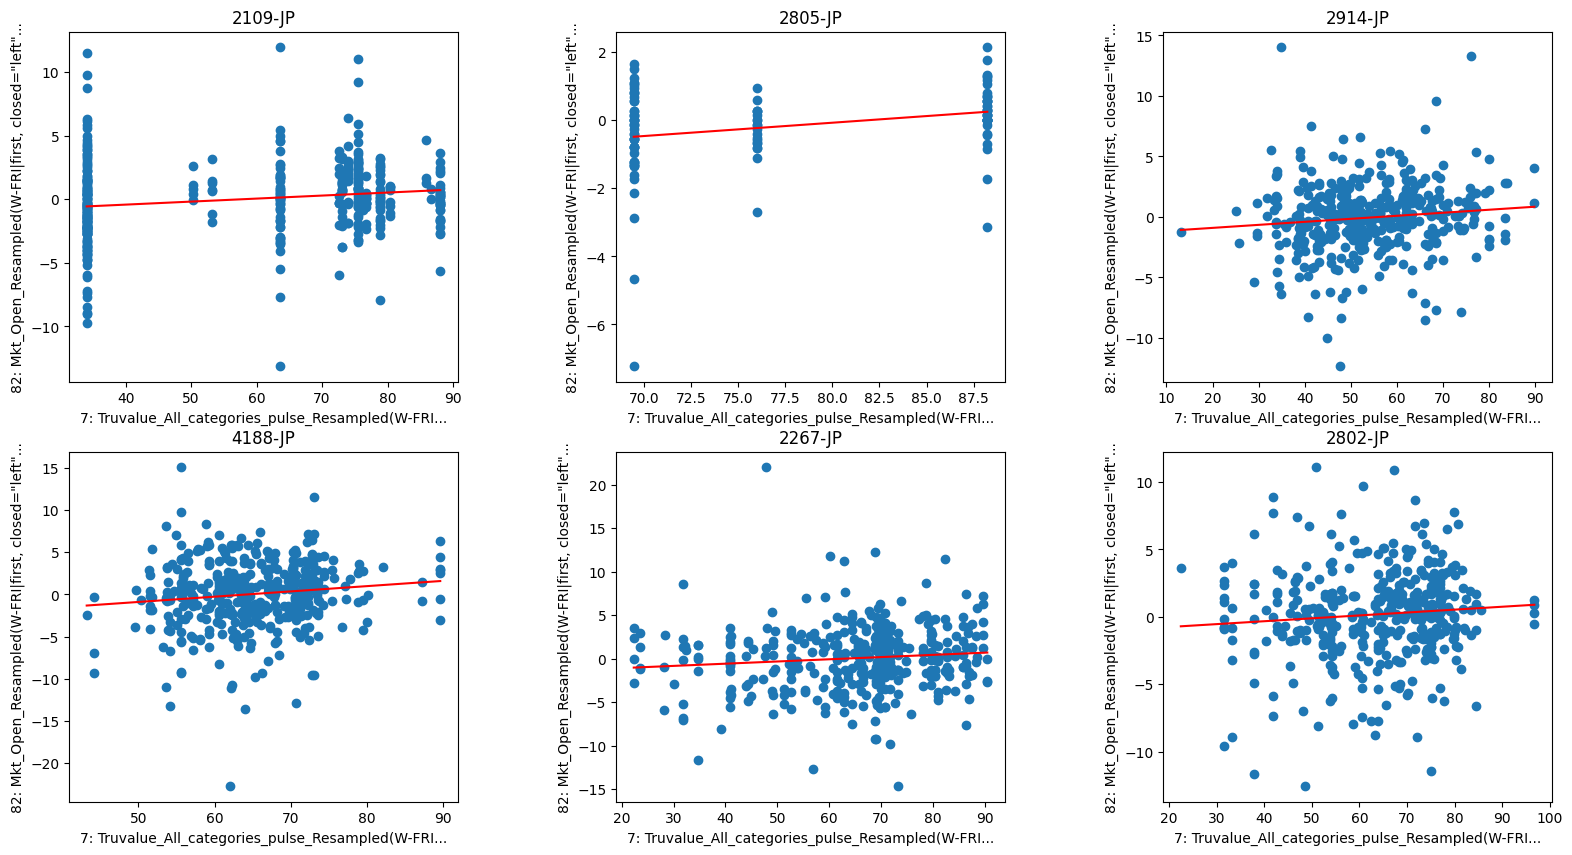

In [15]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=open_return,
    x=feature_last,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45
)

##### 2.resample - mean

In [16]:
tv_shift4_mean_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=4).resample(rule=resample_term, func='mean', label='left', closed='left').variable_ids
tv_shift8_mean_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=8).resample(rule=resample_term, func='mean', label='left', closed='left').variable_ids
tv_shift12_mean_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=12).resample(rule=resample_term, func='mean', label='left', closed='left').variable_ids
tv_shift16_mean_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=16).resample(rule=resample_term, func='mean', label='left', closed='left').variable_ids
tv_shift20_mean_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=20).resample(rule=resample_term, func='mean', label='left', closed='left').variable_ids

In [17]:
rho_pool_mean = pd.DataFrame()
rho_pool_mean['resample-mean, shift=0'] = ade.compu_rho(tv_mean_W_ids, open_return, rename_features=ori_cols)
rho_pool_mean['resample-mean, shift=4'] = ade.compu_rho(tv_shift4_mean_W_ids, open_return, rename_features=ori_cols)
rho_pool_mean['resample-mean, shift=8'] = ade.compu_rho(tv_shift8_mean_W_ids, open_return, rename_features=ori_cols)
rho_pool_mean['resample-mean, shift=12'] = ade.compu_rho(tv_shift12_mean_W_ids, open_return, rename_features=ori_cols)
rho_pool_mean['resample-mean, shift=16'] = ade.compu_rho(tv_shift16_mean_W_ids, open_return, rename_features=ori_cols)
rho_pool_mean['resample-mean, shift=20'] = ade.compu_rho(tv_shift20_mean_W_ids, open_return, rename_features=ori_cols)

display(rho_pool_mean.xs('t-val', level=1).sort_values(rho_pool_mean.columns[0], ascending=False))

,"resample-mean, shift=0","resample-mean, shift=4","resample-mean, shift=8","resample-mean, shift=12","resample-mean, shift=16","resample-mean, shift=20"
ALL_CATEGORIES_PULSE,3.027893,2.748251,2.600736,2.476466,2.268039,2.236157
ALL_CATEGORIES_INSIGHT,2.952542,2.944172,2.914522,2.937203,2.740546,2.659697
ALL_CATEGORIES_MOMENTUM,2.470122,2.439559,2.408917,2.415241,2.214728,2.127983
MATERIALITY_IND_PCTL,1.808391,0.698062,1.792490,1.504854,-0.638707,0.290414
MATERIALITY_ADJ_INSIGHT,1.668866,1.592929,1.543801,1.579465,1.394710,1.211157
ALL_CATEGORIES_ADJ_INSIGHT,0.725208,0.710626,0.682824,0.690035,0.340552,0.067104


> 上記N件のTickerを確認します.

In [18]:
rho_time = ade.compu_rho(tv_mean_W_ids, open_return, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).head()

An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.


,ALL_CATEGORIES_ADJ_INSIGHT,ALL_CATEGORIES_INSIGHT,ALL_CATEGORIES_MOMENTUM,ALL_CATEGORIES_PULSE,MATERIALITY_ADJ_INSIGHT,MATERIALITY_IND_PCTL
TICKER,,,,,,
2109-JP,2.152904,3.728049,2.367308,3.583086,0.885441,2.034633
2805-JP,1.585890,3.242712,3.018095,3.004423,1.664397,2.098742
2914-JP,2.586101,2.587092,0.869098,2.394223,2.000718,-0.951211
8058-JP,1.396721,1.397530,1.169302,2.142305,1.361169,0.771051
9942-JP,1.113459,1.720045,0.941901,1.989675,0.985791,0.556496


In [19]:
display(sdh.transform.find_variables(tv_mean_W_ids))

feature_mean = 13 # ALL_CATEGORIES_PULSE
feature_mean_m = 8  # MATERIALITY_ADJ_INSIGHT

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
"Truvalue_Materiality_adj_insight_Resampled(W-FRI|mean, closed=""left"", label=""left"", origin=""start_day"")",8,2,FACTSET,TrueValue,Unknown,MATERIALITY_ADJ_INSIGHT,None,None,reference,resample,"rule=""W-FRI"", func=""mean"", closed=""left"", labe...",3
"Truvalue_Materiality_ind_pctl_Resampled(W-FRI|mean, closed=""left"", label=""left"", origin=""start_day"")",9,2,FACTSET,TrueValue,Unknown,MATERIALITY_IND_PCTL,None,None,reference,resample,"rule=""W-FRI"", func=""mean"", closed=""left"", labe...",3
"Truvalue_All_categories_adj_insight_Resampled(W-FRI|mean, closed=""left"", label=""left"", origin=""start_day"")",10,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_ADJ_INSIGHT,None,None,reference,resample,"rule=""W-FRI"", func=""mean"", closed=""left"", labe...",3
"Truvalue_All_categories_insight_Resampled(W-FRI|mean, closed=""left"", label=""left"", origin=""start_day"")",11,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_INSIGHT,None,None,reference,resample,"rule=""W-FRI"", func=""mean"", closed=""left"", labe...",3
"Truvalue_All_categories_momentum_Resampled(W-FRI|mean, closed=""left"", label=""left"", origin=""start_day"")",12,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_MOMENTUM,None,None,reference,resample,"rule=""W-FRI"", func=""mean"", closed=""left"", labe...",3
"Truvalue_All_categories_pulse_Resampled(W-FRI|mean, closed=""left"", label=""left"", origin=""start_day"")",13,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_PULSE,None,None,reference,resample,"rule=""W-FRI"", func=""mean"", closed=""left"", labe...",3


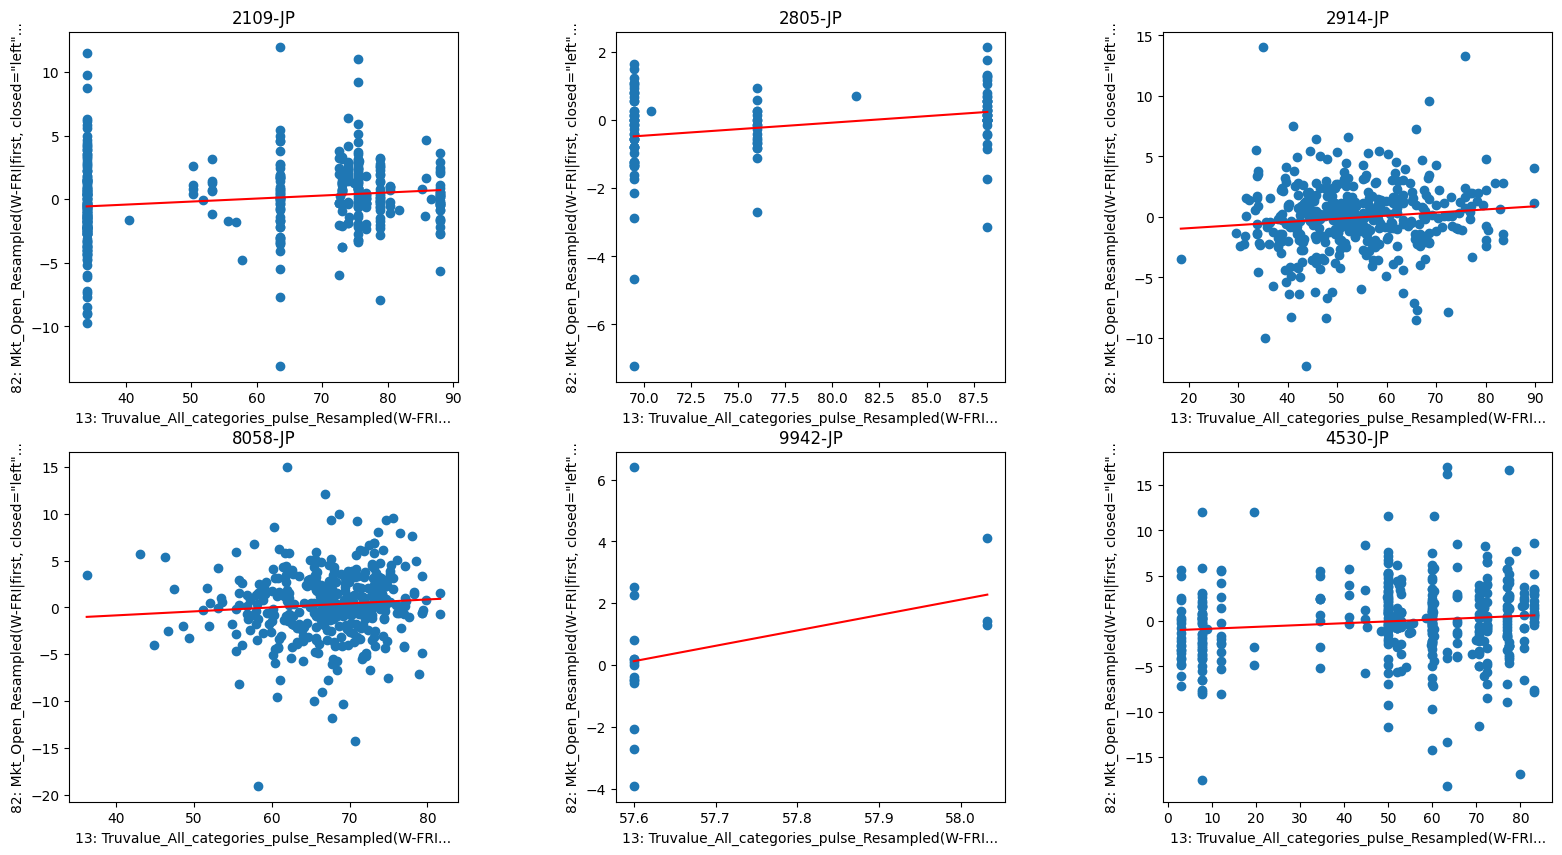

In [20]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=open_return,
    x=feature_mean,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45
)

##### 3. resample - sum

In [21]:
tv_shift4_sum_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=4).resample(rule=resample_term, func='sum', label='left', closed='left').variable_ids
tv_shift8_sum_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=8).resample(rule=resample_term, func='sum', label='left', closed='left').variable_ids
tv_shift12_sum_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=12).resample(rule=resample_term, func='sum', label='left', closed='left').variable_ids
tv_shift16_sum_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=16).resample(rule=resample_term, func='sum', label='left', closed='left').variable_ids
tv_shift20_sum_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=20).resample(rule=resample_term, func='sum', label='left', closed='left').variable_ids

In [22]:
rho_pool_sum = pd.DataFrame()
rho_pool_sum['resample-sum, shift=0'] = ade.compu_rho(tv_sum_W_ids, open_return, rename_features=ori_cols)
rho_pool_sum['resample-sum, shift=4'] = ade.compu_rho(tv_shift4_sum_W_ids, open_return, rename_features=ori_cols)
rho_pool_sum['resample-sum, shift=8'] = ade.compu_rho(tv_shift8_sum_W_ids, open_return, rename_features=ori_cols)
rho_pool_sum['resample-sum, shift=12'] = ade.compu_rho(tv_shift12_sum_W_ids, open_return, rename_features=ori_cols)
rho_pool_sum['resample-sum, shift=16'] = ade.compu_rho(tv_shift16_sum_W_ids, open_return, rename_features=ori_cols)
rho_pool_sum['resample-sum, shift=20'] = ade.compu_rho(tv_shift20_sum_W_ids, open_return, rename_features=ori_cols)

display(rho_pool_sum.xs('t-val', level=1).sort_values(rho_pool_sum.columns[0], ascending=False))

,"resample-sum, shift=0","resample-sum, shift=4","resample-sum, shift=8","resample-sum, shift=12","resample-sum, shift=16","resample-sum, shift=20"
ALL_CATEGORIES_INSIGHT,3.500402,3.503322,3.786229,3.901572,4.424959,4.601273
ALL_CATEGORIES_PULSE,3.461828,3.348912,3.532370,3.684538,4.166711,4.395567
ALL_CATEGORIES_MOMENTUM,3.259583,3.274294,3.398087,3.673722,4.132526,4.365320
MATERIALITY_IND_PCTL,2.911475,2.219451,3.411925,3.461324,2.707604,3.512763
MATERIALITY_ADJ_INSIGHT,2.850422,2.858819,3.454106,3.525823,4.061476,4.164051
ALL_CATEGORIES_ADJ_INSIGHT,2.237829,2.267311,2.837454,2.867907,3.359681,3.418952


> もっとも相関の良い変数のうち、さらに上記N件のTickerを確認します.

In [23]:
rho_time = ade.compu_rho(tv_sum_W_ids, open_return, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).head()

An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.


,ALL_CATEGORIES_ADJ_INSIGHT,ALL_CATEGORIES_INSIGHT,ALL_CATEGORIES_MOMENTUM,ALL_CATEGORIES_PULSE,MATERIALITY_ADJ_INSIGHT,MATERIALITY_IND_PCTL
TICKER,,,,,,
2109-JP,2.152904,3.728049,2.367308,3.583086,0.885441,2.034633
2216-JP,3.335154,3.401057,2.990446,3.251964,3.330121,2.982400
2914-JP,2.586101,2.587092,0.869098,2.394223,2.000718,-0.951211
5410-JP,0.978988,2.488065,2.549546,2.342830,1.457902,-0.072147
8058-JP,1.396414,1.397530,1.169302,2.142305,1.360818,0.771051


> 変数を確認して散布図でplot

In [24]:
display(sdh.transform.find_variables(tv_sum_W_ids))

feature_sum = 19 # ALL_CATEGORIES_PULSE

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
"Truvalue_Materiality_adj_insight_Resampled(W-FRI|sum, closed=""left"", label=""left"", origin=""start_day"")",14,2,FACTSET,TrueValue,Unknown,MATERIALITY_ADJ_INSIGHT,None,None,reference,resample,"rule=""W-FRI"", func=""sum"", closed=""left"", label...",4
"Truvalue_Materiality_ind_pctl_Resampled(W-FRI|sum, closed=""left"", label=""left"", origin=""start_day"")",15,2,FACTSET,TrueValue,Unknown,MATERIALITY_IND_PCTL,None,None,reference,resample,"rule=""W-FRI"", func=""sum"", closed=""left"", label...",4
"Truvalue_All_categories_adj_insight_Resampled(W-FRI|sum, closed=""left"", label=""left"", origin=""start_day"")",16,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_ADJ_INSIGHT,None,None,reference,resample,"rule=""W-FRI"", func=""sum"", closed=""left"", label...",4
"Truvalue_All_categories_insight_Resampled(W-FRI|sum, closed=""left"", label=""left"", origin=""start_day"")",17,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_INSIGHT,None,None,reference,resample,"rule=""W-FRI"", func=""sum"", closed=""left"", label...",4
"Truvalue_All_categories_momentum_Resampled(W-FRI|sum, closed=""left"", label=""left"", origin=""start_day"")",18,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_MOMENTUM,None,None,reference,resample,"rule=""W-FRI"", func=""sum"", closed=""left"", label...",4
"Truvalue_All_categories_pulse_Resampled(W-FRI|sum, closed=""left"", label=""left"", origin=""start_day"")",19,2,FACTSET,TrueValue,Unknown,ALL_CATEGORIES_PULSE,None,None,reference,resample,"rule=""W-FRI"", func=""sum"", closed=""left"", label...",4


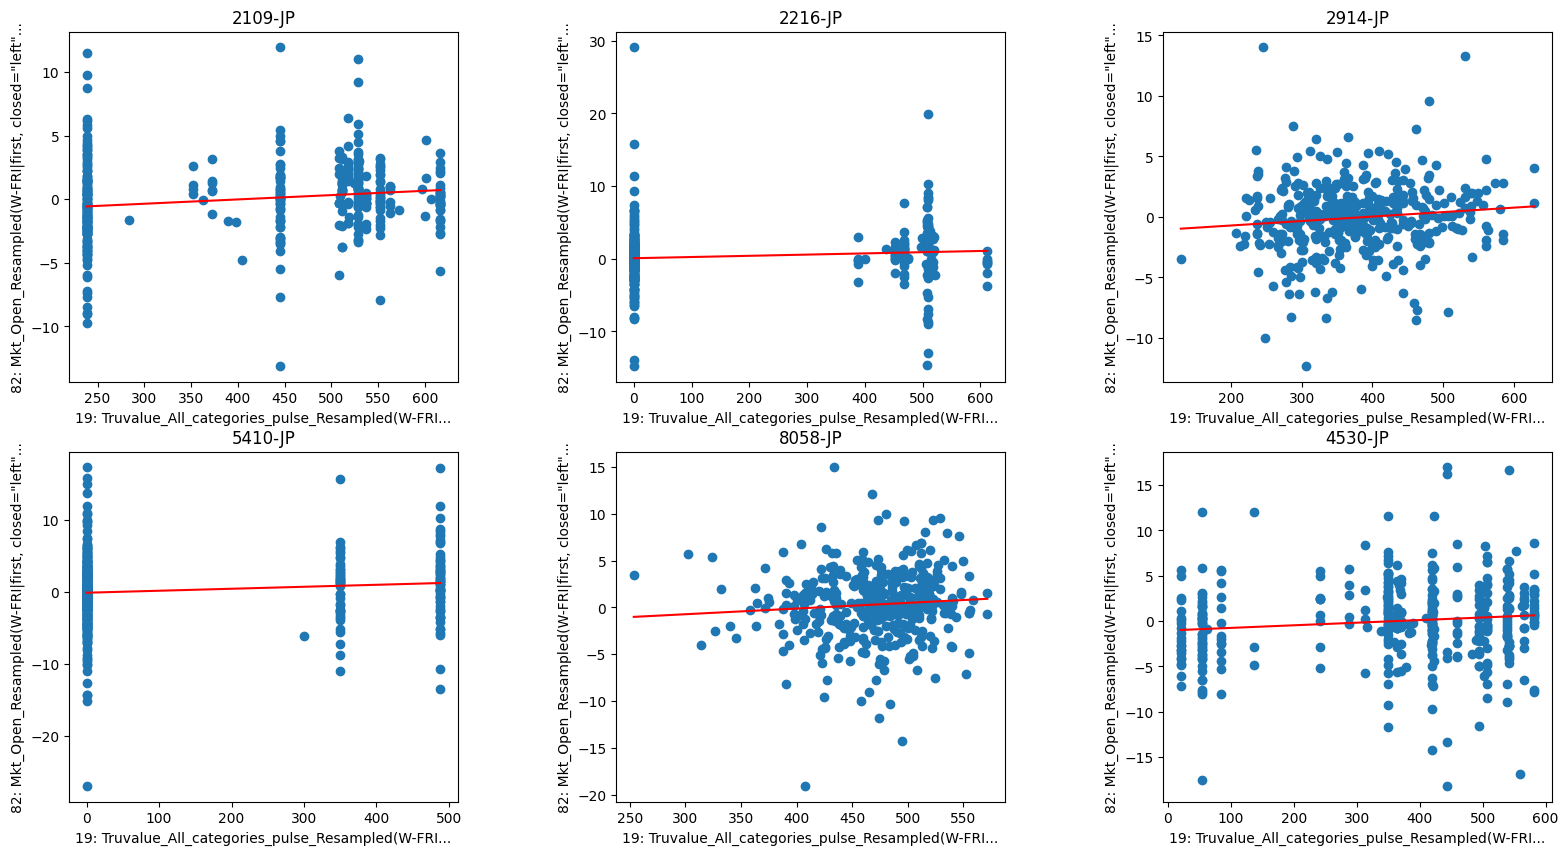

In [25]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=open_return,
    x=feature_sum,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45
)

## バックテスト
> TruValueの集約方法ごとに、株価変化率ともっとも相関の良い特徴量をシグナルにして、ポートフォリオ分析を実施します.

In [26]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

### Resample - last

In [27]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature_last,
    open_return,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-5.665984,-0.718834,16.596356,-0.043313,0.529412,3.259662,-50.778609,-0.014156
#2,23.409880,2.969971,17.184461,0.172829,0.561275,5.969069,-45.566623,0.065179
#3,36.792407,4.667789,16.815884,0.277582,0.583333,4.200489,-40.198806,0.116118
#3-#1,42.458391,5.386622,5.368059,1.003458,0.553922,7.460151,-10.864002,0.495823
#3-#1(cost),42.429275,5.382929,5.368061,1.002770,0.553922,7.460151,-10.865440,0.495417


### Resample - mean

In [28]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature_mean,
    open_return,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-4.403690,-0.558689,16.597979,-0.033660,0.529412,3.109134,-50.744178,-0.011010
#2,25.044298,3.177327,17.234706,0.184356,0.558824,6.042231,-47.412525,0.067014
#3,33.814571,4.289996,16.754855,0.256045,0.568627,3.894071,-39.554151,0.108459
#3-#1,38.218261,4.848685,5.294133,0.915860,0.531863,7.003205,-11.380806,0.426041
#3-#1(cost),38.190929,4.845217,5.294138,0.915204,0.531863,7.003205,-11.382149,0.425686


### Resample - sum

In [29]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature_sum,
    open_return,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,12.493963,1.585087,13.726875,0.115473,0.568627,0.833495,-46.515563,0.034076
#2,24.959811,3.166608,16.806572,0.188415,0.546569,2.144055,-42.184962,0.075065
#3,16.194505,2.054569,4.583198,0.448283,0.610390,0.718677,-6.550291,0.313661
#3-#1,3.700542,0.469481,13.560181,0.034622,0.463235,1.552173,-46.973423,0.009995
#3-#1(cost),3.694484,0.468713,13.560186,0.034565,0.463235,1.552173,-46.973882,0.009978
